<a href="https://colab.research.google.com/github/BIRENBISOYI/ASSIGNMENT---2/blob/main/ML_lab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload loan_data.csv via the file-picker.


Saving loan_data.csv to loan_data.csv
Uploaded: /content/loan_data.csv
Loaded shape: (268114, 13)
Columns: ['id', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'loan_paid_back']


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1


Numeric cols: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
Categorical cols: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose']
Train/test sizes: (214491, 12) (53623, 12)
Train target distribution:
 loan_paid_back
1    0.79842
0    0.20158
Name: proportion, dtype: float64
Test target distribution:
 loan_paid_back
1    0.798426
0    0.201574
Name: proportion, dtype: float64
Using OneHotEncoder(sparse_output=False)
Tuning Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
LR best params: {'clf__C': 0.01, 'clf__class_weight': None} CV AUC: nan
Tuning Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
RF best params: {'clf__class_weight': None, 'clf__max_depth': 6, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 100} CV AUC: nan
Test ROC AUC - LogisticRegression: 0.9104, RandomForest: 0.9023
Chosen model: LogisticRegression Test AUC: 0.9104064150392968


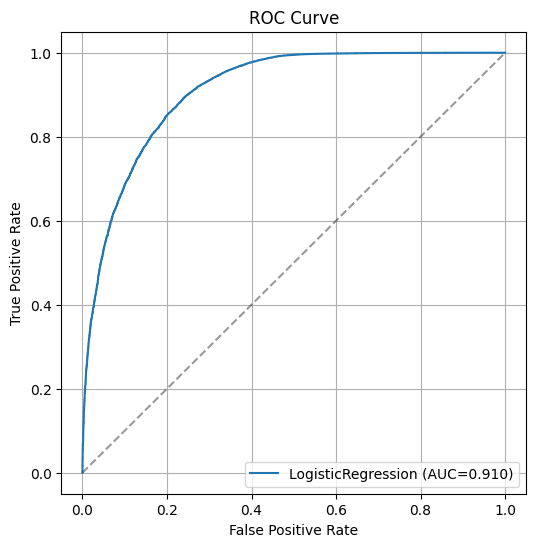


--- AUC by education_level ---


,education_level,n,AUC
4,Other,2336,0.923176
0,Bachelor's,25263,0.911348
2,High School,16701,0.908436
1,Master's,8341,0.907291
3,PhD,982,0.905718



--- AUC by loan_purpose (top3 / bottom3) ---


,loan_purpose,n,AUC
1,Education,3202,0.922794
5,Vacation,760,0.918917
4,Medical,2088,0.916579
3,Home,4027,0.912499
7,Other,5785,0.911430
0,Business,3091,0.910109
2,Debt consolidation,29317,0.909639
6,Car,5353,0.899492



Top 3 loan purposes by AUC:


,loan_purpose,n,AUC
1,Education,3202,0.922794
5,Vacation,760,0.918917
4,Medical,2088,0.916579



Bottom 3 loan purposes by AUC:


,loan_purpose,n,AUC
0,Business,3091,0.910109
2,Debt consolidation,29317,0.909639
6,Car,5353,0.899492



--- Feature explainability ---
Top positive coefficients (increase prob of 'paid back'):


,feature,coef
18,employment_status_Retired,2.326928
17,employment_status_Employed,1.379354
19,employment_status_Self-employed,1.308539
2,credit_score,0.739415
16,education_level_PhD,0.139299
26,loan_purpose_Home,0.109412
22,loan_purpose_Business,0.061314
11,marital_status_Widowed,0.047041
5,gender_Female,0.030094
23,loan_purpose_Car,0.026306


Top negative coefficients:


,feature,coef
24,loan_purpose_Debt consolidation,-0.029109
9,marital_status_Married,-0.032239
15,education_level_Other,-0.035471
4,interest_rate,-0.049272
27,loan_purpose_Medical,-0.079206
12,education_level_Bachelor's,-0.092553
25,loan_purpose_Education,-0.101052
1,debt_to_income_ratio,-0.829756
20,employment_status_Student,-1.676327
21,employment_status_Unemployed,-3.336792



--- Summary ---
Chosen model: LogisticRegression
Test ROC AUC (chosen): 0.9104
Saved test predictions to: /content/loan_test_predictions.csv


In [1]:


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

RANDOM_STATE = 42

# ---------------- USER SETTINGS ----------------
DATA_PATH = "/content/loan_data.csv"   # upload target
TEST_SIZE = 0.20
MIN_GROUP_SIZE = 30   # min samples to include a loan_purpose in ranking
SAVE_PRED_PATH = "/content/loan_test_predictions.csv"
# -----------------------------------------------

# Upload file if not present (Colab)
if not os.path.exists(DATA_PATH):
    print("Please upload loan_data.csv via the file-picker.")
    from google.colab import files
    uploaded = files.upload()
    if len(uploaded) == 0:
        raise FileNotFoundError("No file uploaded.")
    uploaded_name = list(uploaded.keys())[0]
    if uploaded_name != os.path.basename(DATA_PATH):
        os.rename(uploaded_name, DATA_PATH)
    print("Uploaded:", DATA_PATH)

# Load dataset
df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

# Ensure target exists
if 'loan_paid_back' not in df.columns:
    raise ValueError("Target column 'loan_paid_back' not found in dataset.")

# Identify numeric and categorical features (adapt to columns present)
num_cols = [c for c in ['annual_income','debt_to_income_ratio','credit_score','loan_amount','interest_rate'] if c in df.columns]
cat_cols = [c for c in ['gender','marital_status','education_level','employment_status','loan_purpose','grade','subgrade'] if c in df.columns]
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# Drop id if present
if 'id' in df.columns:
    df = df.drop(columns=['id'])

# Train/test split (stratify by target)
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, stratify=df['loan_paid_back'], random_state=RANDOM_STATE)
print("Train/test sizes:", train_df.shape, test_df.shape)
print("Train target distribution:\n", train_df['loan_paid_back'].value_counts(normalize=True))
print("Test target distribution:\n", test_df['loan_paid_back'].value_counts(normalize=True))

# ---------------- Preprocessing pipeline (OneHotEncoder compatibility) ----------------
ohe_kwargs = {'handle_unknown':'ignore'}
try:
    # newer sklearn
    OneHotEncoder(sparse_output=False, **ohe_kwargs)
    ohe = OneHotEncoder(sparse_output=False, **ohe_kwargs)
    print("Using OneHotEncoder(sparse_output=False)")
except TypeError:
    ohe = OneHotEncoder(sparse=False, **ohe_kwargs)
    print("Using OneHotEncoder(sparse=False)")

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', ohe)
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

# ---------------- Model pipelines & small grids ----------------
lr_pipe = Pipeline([('preproc', preprocessor), ('clf', LogisticRegression(solver='saga', max_iter=2000, random_state=RANDOM_STATE))])
rf_pipe = Pipeline([('preproc', preprocessor), ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=1))])

lr_grid = {'clf__C': [0.01, 0.1, 1.0], 'clf__class_weight': [None, 'balanced']}
rf_grid = {'clf__n_estimators': [100], 'clf__max_depth': [6, 12, None], 'clf__min_samples_leaf': [1, 5], 'clf__class_weight': [None, 'balanced']}

# Use ROC AUC scoring
scorer = make_scorer(roc_auc_score, needs_proba=True)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# ---------- Grid search logistic regression ----------
print("Tuning Logistic Regression...")
lr_search = GridSearchCV(lr_pipe, lr_grid, scoring=scorer, cv=cv, n_jobs=1, verbose=1)
lr_search.fit(train_df[num_cols + cat_cols], train_df['loan_paid_back'])
print("LR best params:", lr_search.best_params_, "CV AUC:", lr_search.best_score_)

# ---------- Grid search random forest ----------
print("Tuning Random Forest...")
rf_search = GridSearchCV(rf_pipe, rf_grid, scoring=scorer, cv=cv, n_jobs=1, verbose=1)
rf_search.fit(train_df[num_cols + cat_cols], train_df['loan_paid_back'])
print("RF best params:", rf_search.best_params_, "CV AUC:", rf_search.best_score_)

# ---------- Evaluate on test ----------
best_lr = lr_search.best_estimator_
best_rf = rf_search.best_estimator_

lr_probs = best_lr.predict_proba(test_df[num_cols + cat_cols])[:,1]
rf_probs = best_rf.predict_proba(test_df[num_cols + cat_cols])[:,1]

lr_auc = roc_auc_score(test_df['loan_paid_back'], lr_probs)
rf_auc = roc_auc_score(test_df['loan_paid_back'], rf_probs)
print(f"Test ROC AUC - LogisticRegression: {lr_auc:.4f}, RandomForest: {rf_auc:.4f}")

# Pick single architecture
if lr_auc >= rf_auc:
    best_model = best_lr; best_probs = lr_probs; chosen_name = "LogisticRegression"; chosen_auc = lr_auc
else:
    best_model = best_rf; best_probs = rf_probs; chosen_name = "RandomForest"; chosen_auc = rf_auc

print("Chosen model:", chosen_name, "Test AUC:", chosen_auc)

# ---------- Save predictions to preds_out (ensures same DF used for subgroup masks) ----------
preds_out = test_df.reset_index(drop=True).copy()
preds_out['pred_proba'] = best_probs
preds_out.to_csv(SAVE_PRED_PATH, index=False)
print("Saved test predictions to:", SAVE_PRED_PATH)

# ---------- ROC plot ----------
fpr, tpr, thr = roc_curve(preds_out['loan_paid_back'], preds_out['pred_proba'])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'{chosen_name} (AUC={chosen_auc:.3f})')
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve'); plt.legend(); plt.grid(); plt.show()

# ---------------- Subgroup analysis (FIXED: use preds_out for masking) ----------------
from sklearn.metrics import roc_auc_score

# 1) By education_level (report for each level present)
print("\n--- AUC by education_level ---")
if 'education_level' in preds_out.columns:
    edu_levels = preds_out['education_level'].fillna('MISSING').unique()
    edu_rows = []
    for lvl in edu_levels:
        mask = preds_out['education_level'].fillna('MISSING') == lvl
        y_true = preds_out.loc[mask, 'loan_paid_back']
        y_score = preds_out.loc[mask, 'pred_proba']
        # require at least one positive and one negative to compute AUC and minimum size
        if y_true.nunique() < 2 or len(y_true) < 10:
            auc_val = np.nan
        else:
            auc_val = roc_auc_score(y_true, y_score)
        edu_rows.append({'education_level': lvl, 'n': int(mask.sum()), 'AUC': auc_val})
    edu_df = pd.DataFrame(edu_rows).sort_values('AUC', ascending=False)
    display(edu_df)
else:
    print("Column 'education_level' not found. Skipping.")

# 2) By loan_purpose: compute AUC per purpose, then show top 3 and bottom 3 (with MIN_GROUP_SIZE)
print("\n--- AUC by loan_purpose (top3 / bottom3) ---")
if 'loan_purpose' in preds_out.columns:
    purpose_vals = preds_out['loan_purpose'].fillna('MISSING').unique()
    purpose_rows = []
    for p in purpose_vals:
        mask = preds_out['loan_purpose'].fillna('MISSING') == p
        y_true = preds_out.loc[mask, 'loan_paid_back']
        y_score = preds_out.loc[mask, 'pred_proba']
        if y_true.nunique() < 2 or mask.sum() < MIN_GROUP_SIZE:
            auc_val = np.nan
        else:
            auc_val = roc_auc_score(y_true, y_score)
        purpose_rows.append({'loan_purpose': p, 'n': int(mask.sum()), 'AUC': auc_val})
    purpose_df = pd.DataFrame(purpose_rows).sort_values('AUC', ascending=False)
    display(purpose_df)
    purpose_valid = purpose_df.dropna(subset=['AUC'])
    if not purpose_valid.empty:
        print("\nTop 3 loan purposes by AUC:")
        display(purpose_valid.head(3))
        print("\nBottom 3 loan purposes by AUC:")
        display(purpose_valid.tail(3))
    else:
        print("No loan_purpose groups had enough data / label variation to compute AUC.")
else:
    print("Column 'loan_purpose' not found. Skipping.")

# ---------------- Explainability: coef or feature importances ----------------
print("\n--- Feature explainability ---")
if chosen_name == "LogisticRegression":
    pre = best_model.named_steps['preproc']
    num_feats = num_cols
    ohe_step = pre.named_transformers_['cat'].named_steps['onehot']
    try:
        cat_feature_names = ohe_step.get_feature_names_out(cat_cols).tolist()
    except:
        cat_feature_names = ohe_step.get_feature_names(cat_cols).tolist()
    feat_names = num_feats + cat_feature_names
    coefs = best_model.named_steps['clf'].coef_[0]
    coef_df = pd.DataFrame({'feature': feat_names, 'coef': coefs}).sort_values('coef', ascending=False)
    print("Top positive coefficients (increase prob of 'paid back'):")
    display(coef_df.head(10))
    print("Top negative coefficients:")
    display(coef_df.tail(10))
else:
    pre = best_model.named_steps['preproc']
    num_feats = num_cols
    ohe_step = pre.named_transformers_['cat'].named_steps['onehot']
    try:
        cat_feature_names = ohe_step.get_feature_names_out(cat_cols).tolist()
    except:
        cat_feature_names = ohe_step.get_feature_names(cat_cols).tolist()
    feat_names = num_feats + cat_feature_names
    importances = best_model.named_steps['clf'].feature_importances_
    fi_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
    print("Top feature importances:")
    display(fi_df.head(15))

# ---------------- Final summary ----------------
print("\n--- Summary ---")
print("Chosen model:", chosen_name)
print("Test ROC AUC (chosen): {:.4f}".format(chosen_auc))
print("Saved test predictions to:", SAVE_PRED_PATH)
